In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import scipy.sparse as sp_sparse
from scipy import stats
import scanpy as sc
from math import log
from statistics import median
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras.losses

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Preparation (Normalize & Find Variable Genes)

In [2]:
adata = sc.read_10x_mtx(
    '/home/ahmadazim/data/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata.var_names_make_unique()

In [3]:
data = pd.DataFrame.sparse.from_spmatrix(adata.X)
print('Working on {} cells and {} genes'.format(*data.shape))

Working on 2700 cells and 32738 genes


In [4]:
# Filter out genes that are not expressed in any cells
geneSum = data.sum(axis=0)
x = geneSum.index[geneSum == 0].tolist()
data = data.drop(x, axis = 1)
data.shape

(2700, 16634)

In [5]:
# Normalizing counts matrix (using Seurat method)
scaleFactor = 10000
cellSum  = data.sum(axis=1)
npData = np.asarray(data)
for j in range(2700):
    npData[j,:] = np.log1p((npData[j,:]/cellSum[j]) * scaleFactor)

In [6]:
# Find Variable Genes by calculating coefficient of variation ()
variance = []
mean = []
for i in range(16634):
    variance.append(np.var(npData[:,i]))
    mean.append(np.mean(npData[:,i]))
coeff_var = np.asarray(variance)/np.asarray(mean)

In [7]:
topN = 5000
top_5000 = sorted(range(len(coeff_var)), key=lambda x: coeff_var[x])[-topN:]
coeff_var[top_5000]

array([1.7041737, 1.704179 , 1.704198 , ..., 4.09104  , 5.25226  ,
       5.3573875], dtype=float32)

In [8]:
dataHV = npData[:, top_5000]
dataHV.shape

(2700, 5000)

Working on 2700 cells and 5000 genes
Data imported.


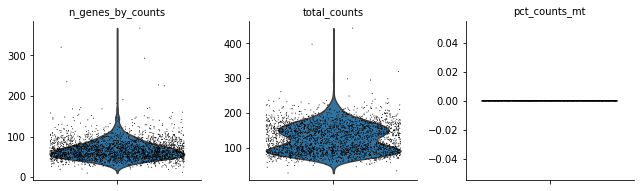

Trying to set attribute `.var` of view, copying.
QC steps done.
Plotting PCA and UMAP...


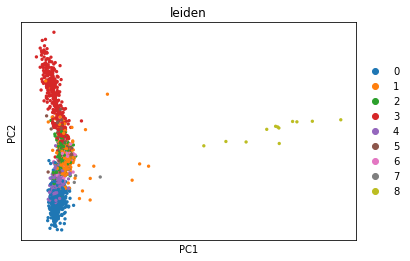

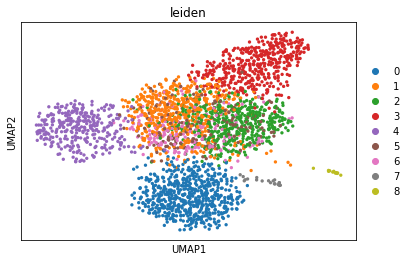

In [13]:
import autoCluster as ac
ac.cluster(inputMat= dataHV, modelName= 'HVdata_5000')
# odd... less highly variable genes = worse clusters

In [23]:
# Create function to mask nonzero values
def create_masked(data, prcntMask):
    dataShape = data.shape
    flat = np.asarray(data.flatten())   # "row-by-row"
    
    nonzeroIndx = np.array(np.where(flat != 0)).flatten()
    numMask = round(len(nonzeroIndx)*prcntMask)
    maskIndx = np.random.choice(nonzeroIndx, size= numMask)

    flat[maskIndx] = 0
    maskedData = flat.reshape(dataShape)

    return(maskedData, maskIndx)

In [66]:
maskedData, maskedIndx = create_masked(npData, 0.4)
pd.DataFrame(maskedData)

0      1      2      3      4      5      6      7      8      9      \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2695    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2696    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2697    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2698    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2699    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      ...  16624     16625  16626  16627     16628  16629     16630  16631  \
0     ...    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000    0.0   
1     ...    0.0  0.000000    0.0    0.0  1.111715    0.0  0.000000    0.0   
2     ...    0.0  2.617574    0.0    0.0  0.000000    0.0  0.000000    0.0   
3     ...    0.0  2.149274    0.0    0.0  0.000000    0.0  0.000000    0.0   
4     ...    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000    0.0   
...   ...    ...       ...    ...    ...       ...    ...       ...    ...   
2695  ...    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000    0.0   
2696  ...    0.0  2.534037    0.0    0.0  0.000000    0.0  0.000000    0.0   
2697  ...    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000    0.0   
2698  ...    0.0  2.376358    0.0    0.0  0.000000    0.0  2.376358    0.0   
2699  ...    0.0  2.779648    0.0    0.0  0.000000    0.0  0.000000    0.0   

      16632  16633  
0       0.0    0.0  
1       0.0    0.0  
2       0.0    0.0  
3       0.0    0.0  
4       0.0    0.0  
...     ...    ...  
2695    0.0    0.0  
2696    0.0    0.0  
2697    0.0    0.0  
2698    0.0    0.0  
2699    0.0    0.0  

[2700 rows x 16634 columns]

In [67]:
model = Sequential()
n_genes = npData.shape[1]

#add model layers
model.add(layers.Input(shape= n_genes))
model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(n_genes, activation='relu'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 8192)              136273920 
_________________________________________________________________
dense_45 (Dense)             (None, 2048)              16779264  
_________________________________________________________________
dense_46 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_47 (Dense)             (None, 2048)              526336    
_________________________________________________________________
dense_48 (Dense)             (None, 8192)              16785408  
_________________________________________________________________
dense_49 (Dense)             (None, 16634)             136282362 
Total params: 307,171,834
Trainable params: 307,171,834
Non-trainable params: 0
________________________________________

In [68]:
def nzMSE(y_true, y_pred): 
    omega = tf.sign(y_true)  # 0 if 0, 1 if > 0
    mse_nz = tf.reduce_mean(tf.multiply(tf.pow( (y_pred - y_true), 2), omega))
    return mse_nz

model.compile(optimizer='adam', 
              loss= nzMSE)

In [69]:
# Train model
AEresults = model.fit(x= maskedData, 
                      y= npData, 
                      epochs= 30, 
                      batch_size= 256)

Epoch 1/30
11/11 [==============================] - 25s 2s/step - loss: 0.1685
Epoch 2/30
11/11 [==============================] - 24s 2s/step - loss: 0.0542
Epoch 3/30
11/11 [==============================] - 24s 2s/step - loss: 0.0382
Epoch 4/30
11/11 [==============================] - 25s 2s/step - loss: 0.0339
Epoch 5/30
11/11 [==============================] - 24s 2s/step - loss: 0.0328
Epoch 6/30
11/11 [==============================] - 24s 2s/step - loss: 0.0322
Epoch 7/30
11/11 [==============================] - 26s 2s/step - loss: 0.0319
Epoch 8/30
11/11 [==============================] - 25s 2s/step - loss: 0.0318
Epoch 9/30
11/11 [==============================] - 24s 2s/step - loss: 0.0317
Epoch 10/30
11/11 [==============================] - 24s 2s/step - loss: 0.0317
Epoch 11/30
11/11 [==============================] - 24s 2s/step - loss: 0.0315
Epoch 12/30
11/11 [==============================] - 25s 2s/step - loss: 0.0304
Epoch 13/30
11/11 [==============================

In [70]:
predicted = pd.DataFrame(model.predict(maskedData))
predicted

0         1      2      3         4         5         6      \
0     1.646062  0.000000    0.0    0.0  1.436851  1.700273  1.571298   
1     1.160549  0.048037    0.0    0.0  1.100525  1.177847  1.210320   
2     1.467115  0.000000    0.0    0.0  1.287175  1.508761  1.422565   
3     1.508439  0.000000    0.0    0.0  1.410841  1.557922  1.488731   
4     2.299896  0.000000    0.0    0.0  1.872029  2.365269  1.963561   
...        ...       ...    ...    ...       ...       ...       ...   
2695  1.391014  0.000000    0.0    0.0  1.309165  1.431657  1.382828   
2696  1.444147  0.000000    0.0    0.0  1.276071  1.484467  1.412797   
2697  1.872016  0.000000    0.0    0.0  1.597009  1.915259  1.722015   
2698  2.341007  0.000000    0.0    0.0  1.954647  2.375083  2.058329   
2699  1.794980  0.000000    0.0    0.0  1.557903  1.848583  1.691453   

         7      8         9      ...  16624     16625     16626     16627  \
0     1.768856    0.0  1.683555  ...    0.0  2.857084  1.643204  1.689261   
1     1.358125    0.0  1.085172  ...    0.0  2.724491  1.151332  1.188015   
2     1.610114    0.0  1.464811  ...    0.0  2.711432  1.462538  1.500929   
3     1.663417    0.0  1.509248  ...    0.0  2.737189  1.563910  1.536653   
4     2.200811    0.0  2.514256  ...    0.0  3.087708  2.345037  2.267275   
...        ...    ...       ...  ...    ...       ...       ...       ...   
2695  1.564297    0.0  1.368141  ...    0.0  2.658208  1.448246  1.410603   
2696  1.592473    0.0  1.434125  ...    0.0  2.721167  1.447577  1.480273   
2697  1.920717    0.0  1.974443  ...    0.0  2.937197  1.886162  1.904710   
2698  2.275417    0.0  2.578393  ...    0.0  3.206703  2.365043  2.332074   
2699  1.886779    0.0  1.876528  ...    0.0  2.948806  1.796356  1.840113   

         16628  16629     16630     16631     16632     16633  
0     1.717882    0.0  1.636883  1.702838  1.752100  1.641849  
1     1.106183    0.0  1.073488  1.248567  1.179988  1.067541  
2     1.506606    0.0  1.428594  1.540689  1.555528  1.433428  
3     1.570320    0.0  1.510767  1.568194  1.612641  1.537926  
4     2.550633    0.0  2.374737  2.248530  2.542399  2.466995  
...        ...    ...       ...       ...       ...       ...  
2695  1.433692    0.0  1.370507  1.464098  1.472997  1.394734  
2696  1.480835    0.0  1.401588  1.528113  1.532043  1.405779  
2697  1.990090    0.0  1.888666  1.902158  2.003665  1.921893  
2698  2.548674    0.0  2.424317  2.316746  2.550598  2.494097  
2699  1.893769    0.0  1.804993  1.836294  1.917194  1.821295  

[2700 rows x 16634 columns]

In [71]:
pd.DataFrame(npData).eq(0).values.sum()/(2700*16634)
predicted.eq(0).values.sum()/(2700*16634)

0.9490805534402985

0.16140622286347908

Working on 2700 cells and 16634 genes
Data imported.


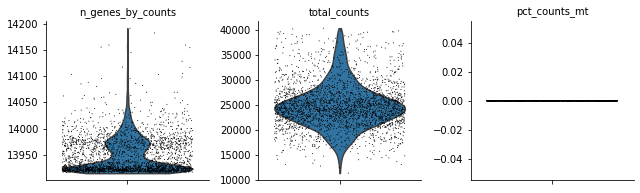

Trying to set attribute `.var` of view, copying.
QC steps done.
Plotting PCA and UMAP...


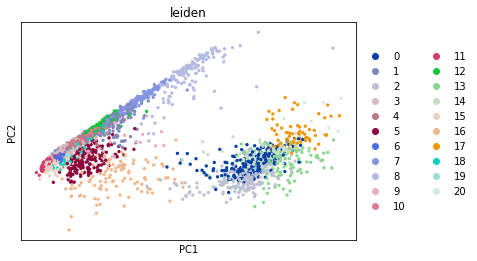

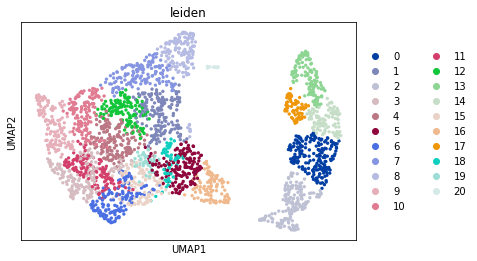

In [72]:
# run autoClust module/function on unImputed data
import autoCluster as ac
ac.cluster(inputMat= predicted, modelName= 'MSEmasked')